All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
cnmr_ir_hnmr_hsqc_seed_42/idx_3_ga_run/3_ga_details.pkl
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.
All generations have the same max score.


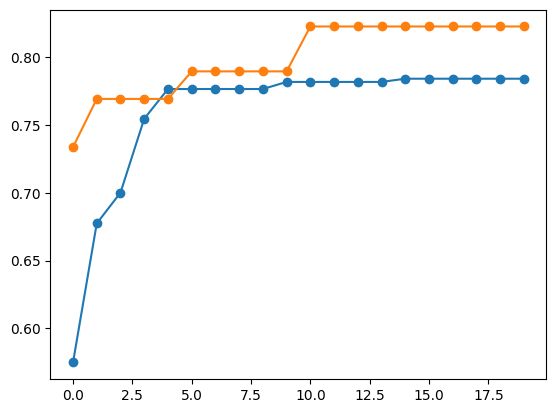

In [195]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

all_pickle = list(Path("cnmr_ir_hnmr_hsqc_seed_42").rglob("idx_*/*.pkl"))


def plot_ga_progress(file):
    df = pd.read_pickle(file)
    max_scores = [d["max"] for d in df.gen_info]
    if len(set(max_scores)) <= 3:
        print("All generations have the same max score.")
        return
    if df.gen_info[0]["max"] < 0.6:
        print(i)
    plt.plot(max_scores, marker="o", label=file.stem)


for i in all_pickle:
    plot_ga_progress(file=i)

In [196]:
import matplotlib as mpl
import numpy as np
from lama_aesthetics.plotutils import range_frame

all_paths_candidates = list(Path("cnmr_ir/analyzer_candidates_output").rglob("*.csv"))
data = pd.read_csv(f"./cnmr_ir/analyzer_candidates_output/{all_paths_candidates[6].name}")
plt.figure(figsize=(5, 3))
plt.style.use("lamalab.mpl")
mpl.rcParams["font.family"] = ["serif"]

range_frame(x=np.array([-0.5, 1]), y=np.array([0, 1]), ax=plt.gca(), pad=0.1)
plt.scatter(data["sum_of_all_individual_similarities"] / 2, data["tanimoto"])
plt.xlabel("mean cosine similarity")
plt.ylabel("Tanimoto similarity")


IndexError: list index out of range

In [ ]:
# ga_ir_raw_emb_path: str | None = "../ir_20250606_2300.pkl",
# ga_cnmr_raw_emb_path: str | None = "../cnmr_pretrain_20250606_2302.pkl",
# ga_hnmr_raw_emb_path: str | None = "../hnmr_augment_pretrain_20250606_2301.pkl",
# ga_hsqc_raw_emb_path: str | None = "../hsqc_20250606_2303.pkl",

import pandas as pd

from molbind.data.analysis import aggregate_embeddings

# read all
ir_embeddings = pd.read_pickle("../ir_20250606_2300.pkl")
cnmr_embeddings = pd.read_pickle("../cnmr_pretrain_20250606_2302.pkl")
hnmr_embeddings = pd.read_pickle("../hnmr_augment_pretrain_20250606_2301.pkl")
hsqc_embeddings = pd.read_pickle("../hsqc_20250606_2303.pkl")

ir_embeddings_agg = aggregate_embeddings(ir_embeddings, modalities=["ir"], central_modality="smiles")
cnmr_embeddings_agg = aggregate_embeddings(cnmr_embeddings, modalities=["c_nmr"], central_modality="smiles")
hnmr_embeddings_agg = aggregate_embeddings(hnmr_embeddings, modalities=["h_nmr"], central_modality="smiles")
hsqc_embeddings_agg = aggregate_embeddings(hsqc_embeddings, modalities=["hsqc"], central_modality="smiles")

In [ ]:
from torch.nn import CosineSimilarity

cos_sim = CosineSimilarity(dim=1, eps=1e-6)

cosines = (
    cos_sim(ir_embeddings_agg["ir"], ir_embeddings_agg["smiles"]).cpu().numpy()
    + cos_sim(cnmr_embeddings_agg["c_nmr"], cnmr_embeddings_agg["smiles"]).cpu().numpy()
    + cos_sim(hnmr_embeddings_agg["h_nmr"], hnmr_embeddings_agg["smiles"]).cpu().numpy()
    + cos_sim(hsqc_embeddings_agg["hsqc"], hsqc_embeddings_agg["smiles"]).cpu().numpy()
) / 4


In [ ]:
import json

data = json.load(open("cnmr_ir_hnmr_hsqc_seed_12/top1_correctness_by_file.json", "r"))
all_results = np.array([*data.values()])
cosines = cosines[: len(all_results)]

# plt.figure(figsize=(5, 3))
plt.style.use("lamalab.mpl")
# can you plot the cosine similarity against the correctness mean binne
mpl.rcParams["font.family"] = ["serif"]

dataframe = pd.DataFrame(
    {"cosine_similarity": (cosines - cosines.min()) / (cosines.max() - cosines.min()), "correctness": all_results}
)

In [ ]:

# Define the number of bins to use
N_BINS = 3

# Create bins of equal width based on cosine similarity scores
# `pd.cut` is perfect for this. It assigns each row to a bin.
dataframe['cosine_bin'] = pd.qcut(dataframe['cosine_similarity'], q=N_BINS)

# Group by the new bins and calculate the necessary statistics for each bin:
# - The mean of `correctness` (this is the y-value, also called "accuracy")
# - The mean of `cosine_similarity` (this is the x-value, also called "confidence")
# - The number of items in each bin (`count`)
binned_data = dataframe.groupby('cosine_bin').agg(
    mean_cosine=('cosine_similarity', 'mean'),
    mean_correctness=('correctness', 'mean'),
    bin_count=('correctness', 'count')
).reset_index()

# --- 3. Plotting the Calibration Curve ---

# Apply the desired style
plt.style.use("lamalab.mpl")
mpl.rcParams['font.family'] = ['serif']

fig, ax = plt.subplots(figsize=(6, 5))

# Plot the "perfect calibration" line (y=x)
ax.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', alpha=0.7)

# Plot the model's calibration curve
ax.plot(binned_data['mean_cosine'], binned_data['mean_correctness'], 'o-', label='Model Calibration')

# --- 4. Enhancing the Plot ---

# Add a histogram in the background to show the distribution of data in bins
# This helps identify if some points on the curve are based on very little data
ax.bar(
    binned_data['mean_cosine'],
    binned_data['bin_count'],
    width=1.0/N_BINS * 0.8, # Make bar width slightly smaller than bin width
    color='gray',
    alpha=0.2,
    label='Data Distribution'
)
ax.set_ylabel("Number of Samples per Bin")
ax.set_ylim(0, binned_data['bin_count'].max() * 1.5) # Give some space at the top

# Set labels and title
ax.set_xlabel("Mean Cosine Similarity (Confidence)")
ax.set_ylabel("Mean Correctness (Accuracy)")
ax.set_title("Calibration Plot")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)\
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Combine legends from both axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

plt.tight_layout()
plt.show()

# You can also print the binned data to inspect it
print("Binned Calibration Data:")
print(binned_data)


In [ ]:
len(list(Path("cnmr_ir_hnmr_hsqc_seed_42").rglob("analyzer_candidates_output/*.csv")))

68

### Check retrieval

In [287]:
from pathlib import Path
import pandas as pd
import pickle
import hashlib
from functools import lru_cache
from concurrent.futures import ProcessPoolExecutor, as_completed
import multiprocessing as mp
from typing import List, Tuple
import os

# Import your function
from molbind.utils.spec2struct import smiles_to_molecular_formula

# Cache directory
CACHE_DIR = Path("cache")
CACHE_DIR.mkdir(exist_ok=True)


def get_file_hash(file_path: Path) -> str:
    """Generate a hash for file content to use as cache key."""
    with open(file_path, "rb") as f:
        content = f.read()
    return hashlib.md5(content).hexdigest()


def get_cache_path(file_path: Path) -> Path:
    """Generate cache file path."""
    file_hash = get_file_hash(file_path)
    return CACHE_DIR / f"{file_path.stem}_{file_hash}.pkl"


@lru_cache(maxsize=10000)
def cached_smiles_to_molecular_formula(smiles: str) -> str:
    """Cached version of smiles_to_molecular_formula to avoid repeated calculations."""
    return smiles_to_molecular_formula(smiles)


def process_single_file(args: Tuple[Path, str]) -> pd.DataFrame:
    """Process a single file with caching."""
    file_path, expected_formula = args

    # Check if cached result exists
    cache_path = get_cache_path(file_path)
    if cache_path.exists():
        with open(cache_path, "rb") as f:
            cached_result = pickle.load(f)
        print(f"Loaded cached result for {file_path.name}")
        return cached_result


    # Process file
    print(f"Processing {file_path.name}...")
    df = pd.read_csv(file_path)

    # Apply molecular formula calculation with caching
    df["molecular_formula"] = df["smiles"].apply(cached_smiles_to_molecular_formula)

    # Filter by expected molecular formula
    filtered_df = df[df["molecular_formula"] == expected_formula].copy()

    # Cache the result
    try:
        with open(cache_path, "wb") as f:
            pickle.dump(filtered_df, f)
        print(f"Cached result for {file_path.name}")
    except Exception as e:
        print(f"Failed to cache {file_path.name}: {e}")

    return filtered_df


def parallel_process_files(max_workers: int = None) -> List[pd.DataFrame]:
    """Main function to process files in parallel with caching."""

    # Get list of files
    list_of_files = list(Path("cnmr_ir_hnmr_hsqc_seed_42").rglob("analyzer_candidates_output/*.csv"))

    # Sort files for consistent processing order
    list_of_files.sort()

    # Extract molecular formulas from filenames
    molecular_formulas = [file.name.split("_")[1].split(".")[0] for file in list_of_files]

    # Prepare arguments for parallel processing
    file_formula_pairs = list(zip(list_of_files, molecular_formulas))

    # Determine number of workers
    if max_workers is None:
        max_workers = min(mp.cpu_count(), len(list_of_files))

    # Process files in parallel
    read_files = []
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Submit all tasks
        future_to_file = {executor.submit(process_single_file, args): args[0] for args in file_formula_pairs}

        # Collect results as they complete
        for future in as_completed(future_to_file):
            file_path = future_to_file[future]
            result = future.result()
            read_files.append(result)

    return read_files


def clear_cache():
    """Clear all cached files."""
    cache_files = list(CACHE_DIR.glob("*.pkl"))
    for cache_file in cache_files:
        cache_file.unlink()


# Process files with parallel execution and caching
read_files = parallel_process_files(max_workers=4)  # Adjust max_workers as needed


Loaded cached result for 12_C15H27N3O5_results.csv
Loaded cached result for 0_C7H12N2O2S_results.csv
Loaded cached result for 10_C6H14N2O_results.csv
Loaded cached result for 14_C16H12F3NO_results.csv
Loaded cached result for 13_C20H19NO6_results.csv
Loaded cached result for 16_C7H7ClN4O_results.csv
Processing 18_C8H6Cl2N2_results.csv...
Loaded cached result for 15_C17H17NO4S_results.csv
Loaded cached result for 1_C15H13FN4O_results.csv
Loaded cached result for 17_C12H17BrN2O3_results.csv
Loaded cached result for 11_C18H20N4O3_results.csv


[08:33:58] WARNING: not removing hydrogen atom without neighbors


Loaded cached result for 200_C22H26N2O6_results.csv
Loaded cached result for 202_C9H12BrNO_results.csv
Loaded cached result for 203_C6H8ClNS_results.csv
Loaded cached result for 201_C18H16ClN3O2_results.csv
Loaded cached result for 206_C15H12ClN3O2_results.csv
Loaded cached result for 205_C23H25NO3_results.csv
Loaded cached result for 204_C14H20BrNO3_results.csv
Loaded cached result for 208_C22H19Cl2F4NO3_results.csvLoaded cached result for 207_C20H21ClN4O4_results.csv

Loaded cached result for 209_C12H19NO5S2_results.csv
Loaded cached result for 211_C19H19FN4_results.csvLoaded cached result for 212_C5H11NO2_results.csv

Loaded cached result for 210_C27H24N2O5_results.csv
Loaded cached result for 215_C20H17ClF3NO5_results.csv
Loaded cached result for 214_C14H20O4S_results.csv
Loaded cached result for 216_C12H12FN3O4_results.csvLoaded cached result for 213_C26H27N3O5S_results.csv

Loaded cached result for 3_C16H14ClN3O2S_results.csv
Loaded cached result for 401_C20H13ClN2O2S_results.csv

[08:33:59] WARNING: not removing hydrogen atom without neighbors
[08:33:59] WARNING: not removing hydrogen atom without neighbors


Loaded cached result for 404_C14H13ClO_results.csvLoaded cached result for 403_C13H13ClN2O4_results.csv

Loaded cached result for 2_C17H17N3O_results.csv
Loaded cached result for 405_C17H13N3O3_results.csv
Loaded cached result for 406_C11H13N3_results.csv
Loaded cached result for 407_C10H12ClNO_results.csv
Loaded cached result for 408_C21H20F2N2O3_results.csv
Loaded cached result for 409_C22H21FN6O_results.csv
Loaded cached result for 412_C17H16O4_results.csv
Loaded cached result for 411_C16H17F2N3O2_results.csv
Loaded cached result for 413_C21H21ClN2O5S_results.csv
Loaded cached result for 410_C14H16O3_results.csv
Loaded cached result for 414_C20H16F6N2O3_results.csvCached result for 18_C8H6Cl2N2_results.csv

Loaded cached result for 5_C29H26O2_results.csv
Loaded cached result for 6_C26H29ClN4O4_results.csv
Loaded cached result for 7_C28H29N3O2S_results.csv
Loaded cached result for 9_C16H19FN6OS_results.csvLoaded cached result for 8_C18H17FO2_results.csv

Loaded cached result for 4_C1

[08:33:59] WARNING: not removing hydrogen atom without neighbors
[08:34:00] WARNING: not removing hydrogen atom without neighbors
[08:34:00] WARNING: not removing hydrogen atom without neighbors
[08:34:00] WARNING: not removing hydrogen atom without neighbors
[08:34:02] WARNING: not removing hydrogen atom without neighbors
[08:34:02] WARNING: not removing hydrogen atom without neighbors
[08:34:02] WARNING: not removing hydrogen atom without neighbors
[08:34:02] WARNING: not removing hydrogen atom without neighbors
[08:34:02] WARNING: not removing hydrogen atom without neighbors
[08:34:02] WARNING: not removing hydrogen atom without neighbors
[08:34:02] WARNING: not removing hydrogen atom without neighbors
[08:34:02] WARNING: not removing hydrogen atom without neighbors
[08:34:02] WARNING: not removing hydrogen atom without neighbors
[08:34:02] WARNING: not removing hydrogen atom without neighbors
[08:34:02] WARNING: not removing hydrogen atom without neighbors
[08:34:02] WARNING: not r

Cached result for 415_C17H24N2O4_results.csv


In [289]:
metrics = ["similarity", "ir_similarity", "cnmr_similarity", "hnmr_similarity", "hsqc_similarity"]


def retrieval(metric: list | str):
    retrieval = {"top_1": [], "top_3": [], "top_5": []}

    no_sim_1_count = 0
    if isinstance(metric, list):
        metrics = "sum"
    else:
        metrics = metric

    for i, file in enumerate(read_files):

        if 1 not in file.tanimoto.values.tolist():
            no_sim_1_count += 1
            continue
        # if metric is a list add a new column summing the values
        if isinstance(metric, list):
            file["sum"] = file[metric].sum(axis=1)

        sorted_file = file.sort_values(by=metrics, ascending=False)
        if 1.0 in sorted_file.tanimoto.values.tolist()[:5]:
            retrieval["top_5"].append(1)
        else:
            retrieval["top_5"].append(0)
        if 1.0 in sorted_file.tanimoto.values.tolist()[:3]:
            retrieval["top_3"].append(1)
        else:
            retrieval["top_3"].append(0)
        if 1.0 in sorted_file.tanimoto.values.tolist()[:1]:
            retrieval["top_1"].append(1)
        else:
            retrieval["top_1"].append(0)
    return retrieval, no_sim_1_count


# retrieval("hsqc_similarity"), retrieval("cnmr_similarity"), retrieval("hnmr_similarity"), retrieval("ir_similarity"), retrieval("similarity")

hsqc, no_sim_1_count = retrieval("hsqc_similarity")
print("HSQC     Top 1", sum(hsqc["top_1"]) / (len(hsqc["top_1"]) - no_sim_1_count))

hnmr, no_sim_1_count = retrieval("hnmr_similarity")
print("1H NMR   Top 1", sum(hnmr["top_1"]) / (len(hnmr["top_1"]) - no_sim_1_count))

cnmr, no_sim_1_count = retrieval("cnmr_similarity")
print("13C NMR  Top 1", sum(cnmr["top_1"]) / (len(cnmr["top_1"]) - no_sim_1_count))

ir, no_sim_1_count = retrieval("ir_similarity")
print("IR \t Top 1", sum(ir["top_1"]) / (len(ir["top_1"]) - no_sim_1_count))


similarity, no_sim_1_count = retrieval(["ir_similarity", "cnmr_similarity"])
print("Combined (IR, 13C) Top 1", sum(similarity["top_1"]) / (len(similarity["top_1"]) - no_sim_1_count))

similarity, no_sim_1_count = retrieval(["ir_similarity", "hnmr_similarity"])
print("Combined (IR, 1H NMR) Top 1", sum(similarity["top_1"]) / (len(similarity["top_1"]) - no_sim_1_count))

similarity, no_sim_1_count = retrieval(["ir_similarity", "hsqc_similarity"])
print("Combined (IR, HSQC) Top 1", sum(similarity["top_1"]) / (len(similarity["top_1"]) - no_sim_1_count))

similarity, no_sim_1_count = retrieval(["cnmr_similarity", "hnmr_similarity"])
print("Combined (13C NMR, 1H NMR) Top 1", sum(similarity["top_1"]) / (len(similarity["top_1"]) - no_sim_1_count))

similarity, no_sim_1_count = retrieval(["cnmr_similarity", "hsqc_similarity"])
print("Combined (13C NMR, HSQC) Top 1", sum(similarity["top_1"]) / (len(similarity["top_1"]) - no_sim_1_count))

similarity, no_sim_1_count = retrieval(["hnmr_similarity", "hsqc_similarity"])
print("Combined (1H NMR, HSQC) Top 1", sum(similarity["top_1"]) / (len(similarity["top_1"]) - no_sim_1_count))

similarity, no_sim_1_count = retrieval(["ir_similarity", "cnmr_similarity", "hnmr_similarity"])
print("Combined (IR, 13C NMR, 1H NMR) Top 1", sum(similarity["top_1"]) / (len(similarity["top_1"]) - no_sim_1_count))

similarity, no_sim_1_count = retrieval(["ir_similarity", "cnmr_similarity", "hsqc_similarity"])
print("Combined (IR, 13C NMR, HSQC) Top 1", sum(similarity["top_1"]) / (len(similarity["top_1"]) - no_sim_1_count))

similarity, no_sim_1_count = retrieval(["ir_similarity", "hnmr_similarity", "hsqc_similarity"])
print("Combined (IR, 1H NMR, HSQC) Top 1", sum(similarity["top_1"]) / (len(similarity["top_1"]) - no_sim_1_count))

# all
similarity, no_sim_1_count = retrieval(["ir_similarity", "cnmr_similarity", "hnmr_similarity", "hsqc_similarity"])
print("Combined (IR, 13C NMR, 1H NMR, HSQC) Top 1", sum(similarity["top_1"]) / (len(similarity["top_1"]) - no_sim_1_count))

HSQC     Top 1 0.9423076923076923
1H NMR   Top 1 0.8076923076923077
13C NMR  Top 1 0.9423076923076923
IR 	 Top 1 0.8653846153846154
Combined (IR, 13C) Top 1 0.9423076923076923
Combined (IR, 1H NMR) Top 1 0.9230769230769231
Combined (IR, HSQC) Top 1 0.9423076923076923
Combined (13C NMR, 1H NMR) Top 1 0.9807692307692307
Combined (13C NMR, HSQC) Top 1 0.9807692307692307
Combined (1H NMR, HSQC) Top 1 0.9615384615384616
Combined (IR, 13C NMR, 1H NMR) Top 1 0.9615384615384616
Combined (IR, 13C NMR, HSQC) Top 1 0.9615384615384616
Combined (IR, 1H NMR, HSQC) Top 1 0.9615384615384616
Combined (IR, 13C NMR, 1H NMR, HSQC) Top 1 0.9807692307692307


(29, 29, 0)